<a href="https://colab.research.google.com/github/cvt220106/google-colab/blob/main/tf01_keras_classification_model_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.8.2
sys.version_info(major=3, minor=7, micro=13, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.8.2
keras.api._v2.keras 2.8.0


In [2]:
!nvidia-smi

Tue Jul 26 13:09:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)


In [5]:
a=np.arange(1,10).reshape(3,3)
print(a)
b=a.reshape(3,3,1)
b

[[1 2 3]
 [4 5 6]
 [7 8 9]]


array([[[1],
        [2],
        [3]],

       [[4],
        [5],
        [6]],

       [[7],
        [8],
        [9]]])

In [6]:
# x_train_scaled[1]

In [7]:
model = keras.models.Sequential()
#添加卷积层，filters输出有多少通道，就是有多少卷积核，kernel_size卷积核的大小，
# padding是否加上padding，same代表输出和输入大小一样，1代表通道数目是1
model.add(keras.layers.Conv2D(filters=32, kernel_size=3,
                              padding='same',
                              activation='relu',
                              input_shape=(28, 28, 1)))
model.add(keras.layers.Conv2D(filters=32, kernel_size=3,
                              padding='same',
                              activation='relu'))
#添加池化层，pool_size是窗口大小，步长默认和窗口大小相等
model.add(keras.layers.MaxPool2D(pool_size=2))
#为了缓解损失，所以filters翻倍
model.add(keras.layers.Conv2D(filters=64, kernel_size=3,
                              padding='same',
                              activation='relu'))
model.add(keras.layers.Conv2D(filters=64, kernel_size=3,
                              padding='same',
                              activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(filters=128, kernel_size=3,
                              padding='same',
                              activation='relu'))
model.add(keras.layers.Conv2D(filters=128, kernel_size=3,
                              padding='same',
                              activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "sgd",
              metrics = ["accuracy"])

> 参数个数的计算:param=卷积核(3x3)x当前层的卷积核数x上一层的输出层数+当前层卷积核数;相当于wx+b<br>
> 320=(3x3)x1x32+32
> 9248=(3x3)x32x32+32

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                    

In [9]:
# model.variables

In [10]:
32*32*9+32

9248

In [11]:
!ls

sample_data


In [12]:
!rm -rf cnn-relu-callbacks

In [13]:
logdir = './cnn-relu-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]
history = model.fit(x_train_scaled, y_train, epochs=100,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks = callbacks)

Epoch 1/100
1719/1719 [==============================] - 21s 5ms/step - loss: 0.7817 - accuracy: 0.7144 - val_loss: 0.4506 - val_accuracy: 0.8314
Epoch 2/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4196 - accuracy: 0.8447 - val_loss: 0.3788 - val_accuracy: 0.8554
Epoch 3/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3529 - accuracy: 0.8693 - val_loss: 0.3461 - val_accuracy: 0.8696
Epoch 4/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3200 - accuracy: 0.8813 - val_loss: 0.3098 - val_accuracy: 0.8844
Epoch 5/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2964 - accuracy: 0.8905 - val_loss: 0.3211 - val_accuracy: 0.8820
Epoch 6/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2780 - accuracy: 0.8974 - val_loss: 0.2927 - val_accuracy: 0.8902
Epoch 7/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2620 - accuracy: 0.9035 - val_loss: 0.2823 - val_a

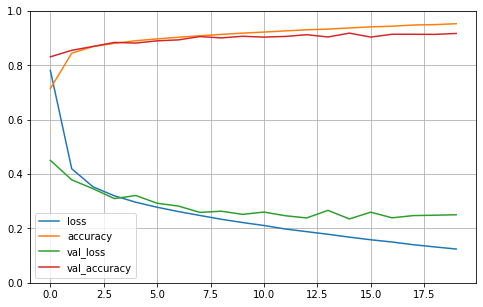

In [14]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [15]:
model.evaluate(x_test_scaled, y_test, verbose = 0)

[0.2705853581428528, 0.9115999937057495]

In [16]:
#通过下面方法来确定某一层输出尺寸
x = tf.constant([[1., 2., 3.],
                 [4., 5., 6.],
                 [7., 8., 9.]])
x = tf.reshape(x, [1, 3, 3, 1])
max_pool_2d = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
   strides=(1, 1), padding='valid')

In [17]:
x

<tf.Tensor: shape=(1, 3, 3, 1), dtype=float32, numpy=
array([[[[1.],
         [2.],
         [3.]],

        [[4.],
         [5.],
         [6.]],

        [[7.],
         [8.],
         [9.]]]], dtype=float32)>

In [18]:
max_pool_2d(x)

<tf.Tensor: shape=(1, 2, 2, 1), dtype=float32, numpy=
array([[[[5.],
         [6.]],

        [[8.],
         [9.]]]], dtype=float32)>

In [19]:
gmp = tf.keras.layers.GlobalMaxPooling2D()
gmp(x)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[9.]], dtype=float32)>